In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch


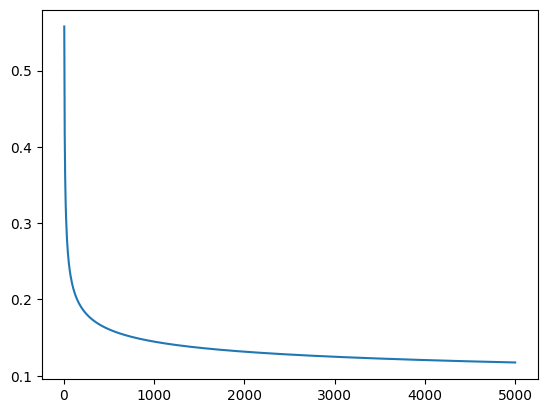

In [2]:
linspace = np.linspace(0, 5000, 1000)
x = torch.tensor(linspace, requires_grad=False)
y = 1/torch.log(x+1)

plt.plot(linspace, y.numpy())

In [3]:
# batch, player, position(x, y)
team = torch.tensor([[[1, 2], [3, 4]], [[7, 8], [9, 10]]]).float()
target = (0, 0)
target_torch = torch.tensor(target).repeat(team.shape[0], 1).unsqueeze(1).float()
print(team.shape, target_torch.shape)

norm = torch.norm(team - target_torch, dim=2)
print(norm)

torch.Size([2, 2, 2]) torch.Size([2, 1, 2])
tensor([[ 2.2361,  5.0000],
        [10.6301, 13.4536]])


In [4]:
torch.sum(norm, dim=1)

tensor([ 7.2361, 24.0838])

In [5]:
scaling = (norm)
foo = scaling * norm
foo_sum = foo.sum(dim=1).unsqueeze(1)
print(foo_sum)
print(norm)
print(norm*foo_sum)

tensor([[ 30.],
        [294.]])
tensor([[ 2.2361,  5.0000],
        [10.6301, 13.4536]])
tensor([[  67.0820,  150.0000],
        [3125.2629, 3955.3655]])


In [19]:
num_frequencies = 5

freq_bands = torch.linspace(1.0, 2 ** (num_frequencies - 1), num_frequencies)
print(freq_bands)

tensor([ 1.0000,  4.7500,  8.5000, 12.2500, 16.0000])


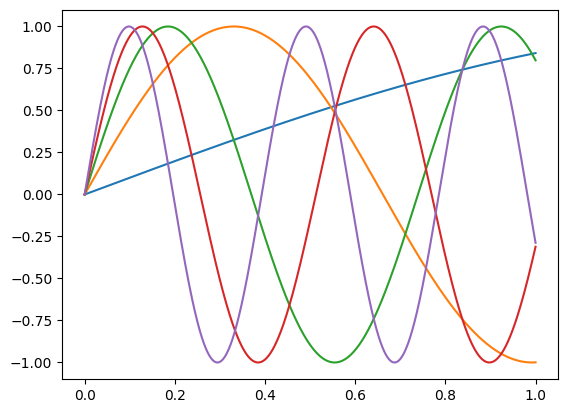

In [20]:
nums = torch.linspace(0, 1, 1000)

for i in range(num_frequencies):
    plt.plot(nums, torch.sin(nums * freq_bands[i]).numpy())
